* [1.Load Data From CSV File](#ld)
* [2.Build a pipeline](#bp)
* [3.Idée pour choisir le meilleur modèle](#ic)
* [4.Modèles de machine learning choisis](#mml)


In [6]:
#!pip install xgboost

In [7]:
#!pip install lightgbm 

In [1]:
#!pip install shap

     -------------------------------------- 435.6/435.6 KB 3.9 MB/s eta 0:00:00
     ---------------------------------------- 2.5/2.5 MB 12.0 MB/s eta 0:00:00
     ---------------------------------------- 78.5/78.5 KB 1.5 MB/s eta 0:00:00
     ------------------------------------- 952.8/952.8 KB 12.1 MB/s eta 0:00:00
     --------------------------------------- 23.2/23.2 MB 13.1 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 62.1.0
    Uninstalling setuptools-62.1.0:
      Successfully uninstalled setuptools-62.1.0


In [2]:
import pandas as pd
import numpy as np

import missingno as msno
import seaborn as sns

import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder,StandardScaler

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from  xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

import shap
import sklearn

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score,StratifiedGroupKFold
from sklearn.metrics import mean_absolute_error,r2_score
from time import time


from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

In [39]:
############Fonction affichant les variables corrélés en fixant un seuil
def f_strong_correlation(threshold_up ,df2):
    #threshold_up = 0.7
    corr_pairs = df2.corr().unstack().sort_values(kind="quicksort")
    strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold_up)])
               .reset_index().rename(columns={0:'corr_coeff'}))
    strong_corr = strong_corr[(strong_corr.index%2 == 0) & 
                          (strong_corr['level_0'] != strong_corr['level_1'])]
    strong_corr.sort_values('corr_coeff', ascending=False)
    return strong_corr
##################"fonction pour afficher les performances d'un modèle
def f_performance(pip):
    #pip.fit(X_train,y_train)
  
    
    print('******************')
    #Check MSE and RMSE

    y_pred = pip.predict(X_test)
    print(f'MSE : {mean_squared_error(y_test, y_pred):.3f}')
    print(f'RMSE : {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')
    print(f'R2 : {r2_score(y_test, y_pred):.3f}')
##################################################
def f_coeff(pip):
    # Putting together the coefficient and their corresponding variable names
    
    df_coefficient = pd.DataFrame()
    df_coefficient["Columns"] = feature_after_transformer(preprocessor)
    df_coefficient['Estimated Coefficient '] = pd.Series(pip.named_steps['model'].coef_.flatten())
    return df_coefficient
    #print(lreg_coefficient)
####################""
def feature_after_transformer(preprocessor):
    tx = preprocessor.get_params()['transformers']
    feature_names = []
    for name,transformer,features in tx:
        try:
            Var = preprocessor.named_transformers_[name].get_feature_names_out().tolist()
        except AttributeError:
            Var = features
        feature_names = feature_names + Var

    return feature_names

### 1.Load Data From CSV File<a class="anchor" id="ld"></a>

In [10]:
#df = pd.read_csv('prepared_data.csv', sep='\t')
df = pd.read_csv('df_quantile.csv',sep='\t')


In [11]:
df.shape

(1541, 17)

In [12]:
columns=list(df.columns)
columns

['OSEBuildingID',
 '%NaturalGas(kBtu)',
 '%SteamUse(kBtu)',
 'BuildingType',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'SourceEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'tranche_date',
 'BuildingAge',
 'groups_neighborhood',
 'groups_PrimaryPropertyType',
 'GFABuildingRate']

In [13]:
target1='TotalGHGEmissions'
target2='SiteEnergyUse(kBtu)'

In [14]:
f_strong_correlation(0.7 ,df)

,level_0,level_1,corr_coeff
0,PropertyGFATotal,SiteEnergyUse(kBtu),0.716380
2,SiteEnergyUse(kBtu),SourceEUI(kBtu/sf),0.732017
4,TotalGHGEmissions,GHGEmissionsIntensity,0.756458
6,SiteEnergyUse(kBtu),TotalGHGEmissions,0.885268


In [15]:
#ici on élimine 'OSEBuildingID' et 'SiteEnergyUse(kBtu)'(target2)
cols=list(set(columns)-set(['OSEBuildingID','GHGEmissionsIntensity(kBtu/sf)',target2]))
cols

['%NaturalGas(kBtu)',
 'ENERGYSTARScore',
 'groups_PrimaryPropertyType',
 'SourceEUI(kBtu/sf)',
 'GFABuildingRate',
 'PropertyGFATotal',
 'BuildingType',
 'BuildingAge',
 'NumberofBuildings',
 'NumberofFloors',
 'groups_neighborhood',
 '%SteamUse(kBtu)',
 'tranche_date',
 'GHGEmissionsIntensity',
 'TotalGHGEmissions']

In [16]:
df=df[cols]

In [17]:
numercial_cols = [col for col in df.columns if df[col].dtype!="O"]
print(numercial_cols)

['%NaturalGas(kBtu)', 'ENERGYSTARScore', 'SourceEUI(kBtu/sf)', 'GFABuildingRate', 'PropertyGFATotal', 'BuildingAge', 'NumberofBuildings', 'NumberofFloors', '%SteamUse(kBtu)', 'GHGEmissionsIntensity', 'TotalGHGEmissions']


In [18]:
categorical_cols = [col for col in df.columns if df[col].dtype=="O"]
print(categorical_cols)

['groups_PrimaryPropertyType', 'BuildingType', 'groups_neighborhood', 'tranche_date']


In [19]:
df['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus'], dtype=object)

In [20]:
df['groups_neighborhood'].unique()

array(['Various', 'North', 'Central', 'South'], dtype=object)

In [21]:
df['tranche_date'].unique()

array(['tranche_date1', 'tranche_date3', 'tranche_date2', 'tranche_date4'],
      dtype=object)

In [22]:
df['groups_PrimaryPropertyType'].unique()

array(['Various', 'Commerce', 'Health'], dtype=object)

In [23]:
df.shape

(1541, 15)

In [24]:
numercial_cols_for_transformer=list(set(numercial_cols)-set([target1]))

In [25]:
numercial_cols_for_transformer

['NumberofBuildings',
 '%NaturalGas(kBtu)',
 'NumberofFloors',
 '%SteamUse(kBtu)',
 'ENERGYSTARScore',
 'SourceEUI(kBtu/sf)',
 'GFABuildingRate',
 'PropertyGFATotal',
 'GHGEmissionsIntensity',
 'BuildingAge']

## 2.Build a pipeline <a class="anchor" id="bp"></a>

In [44]:
# Create pipelines for numerical and categorical features
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore",drop='first')
 #when using sklearn.compose.ColumnTransformer You need to make sure the output column is not included in the data you create your Preprocessing pipeline with
# Create ColumnTransformer to apply pipeline for each column type
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numercial_cols_for_transformer),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [43]:
feature_after_transformer(preprocessor)

['NumberofBuildings',
 '%NaturalGas(kBtu)',
 'NumberofFloors',
 '%SteamUse(kBtu)',
 'ENERGYSTARScore',
 'SourceEUI(kBtu/sf)',
 'GFABuildingRate',
 'PropertyGFATotal',
 'GHGEmissionsIntensity',
 'BuildingAge',
 'groups_PrimaryPropertyType_Health',
 'groups_PrimaryPropertyType_Various',
 'BuildingType_NonResidential',
 'BuildingType_Nonresidential COS',
 'BuildingType_SPS-District K-12',
 'groups_neighborhood_North',
 'groups_neighborhood_South',
 'groups_neighborhood_Various',
 'tranche_date_tranche_date2',
 'tranche_date_tranche_date3',
 'tranche_date_tranche_date4']

In [45]:
y=df[[target1]]
y= StandardScaler().fit_transform(y)
features=list(set(cols)-set([target1]))
X=df[features]

#### Continuous target stratification

In [46]:
bins = np.linspace(0, len(y), 100)

# Save your Y values in a new ndarray,
# broken down by the bins created above.

y_binned = np.digitize(y, bins)

# Pass y_binned to the stratify argument,
# and sklearn will handle the rest

In [31]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y_binned,random_state=0)

## 3.Idée pour choisir le meilleur modèle <a class="anchor" id="ic"></a>

In [32]:
regressors = [LinearRegression(fit_intercept=True,normalize=True,copy_X=True),
              Ridge(alpha=5,solver='auto',fit_intercept=True),
              Lasso(tol=1e-3,selection='random',fit_intercept=True),
              ElasticNet(tol=1e-3,selection='random',fit_intercept=True),
              RandomForestRegressor(n_estimators=300,max_leaf_nodes=1000,criterion='squared_error'),
              SVR(kernel='rbf',degree=3,gamma='scale'),
              LGBMRegressor(boosting_type='gbdt',num_leaves=31,max_depth=1),
              XGBRegressor(objective ='reg:squarederror',booster="dart",
                  n_estimators = 100)
              ]

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

for model in regressors:
    start = time()
    #select=SelectKBest(score_func=f_regression,k=8)
    #pip = Pipeline(steps=[("preprocessor", preprocessor),("selector",select),("model", model)])
    pip = Pipeline(steps=[("preprocessor", preprocessor),("model", model)])
    
    pip.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = pip.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
   
    print("\tMean squared error:", mean_squared_error(y_test, y_pred))
    print("\tRMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

LinearRegression(normalize=True)
	Training time: 0.357s
	Prediction time: 0.000s
	Mean squared error: 0.043908336252865346
	RMSE: 0.20954316083534041
	R2 score: 0.9582107632023991

Ridge(alpha=5)
	Training time: 0.016s
	Prediction time: 0.000s
	Mean squared error: 0.04409020193667629
	RMSE: 0.20997666998187273
	R2 score: 0.9580376747008815

Lasso(selection='random', tol=0.001)
	Training time: 0.016s
	Prediction time: 0.016s
	Mean squared error: 1.0533994455165316
	RMSE: 1.0263524957423409
	R2 score: -0.0025603934897266978

ElasticNet(selection='random', tol=0.001)
	Training time: 0.016s
	Prediction time: 0.000s
	Mean squared error: 0.7519521672621693
	RMSE: 0.8671517556126893
	R2 score: 0.28433846827577225

RandomForestRegressor(max_leaf_nodes=1000, n_estimators=300)
	Training time: 2.982s
	Prediction time: 0.071s
	Mean squared error: 0.024964812950511377
	RMSE: 0.15800257260725656
	R2 score: 0.976240036197485

SVR()
	Training time: 0.094s
	Prediction time: 0.016s
	Mean squared error: 

**Note**
<br>
Dans la suite on va travailler sur les 3 modèles retenus ayant les 4 premiers meilleurs coefficiet de détermination r2 notamment LinearRegression,Ridge,SVR et LGBMRegressor.

## 4.Modèles de machine learning choisis<a class="anchor" id="mml"></a>

### 4.1.Regression linéaire

In [ ]:
#LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, 
#and the targets predicted by the linear approximation.

In [47]:

clf_lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LinearRegression(fit_intercept=True,normalize=True,copy_X=True))]
)
clf_lr.fit(X_train,y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   '%NaturalGas(kBtu)',
                                                   'NumberofFloors',
                                                   '%SteamUse(kBtu)',
                                                   'ENERGYSTARScore',
                                                   'SourceEUI(kBtu/sf)',
                                                   'GFABuildingRate',
                                                   'PropertyGFATotal',
                                                   'GHGEmissionsIntensity',
                                                   'BuildingAge']),
                                  

### 4.1.1.Indicateurs de performance

In [36]:
f_performance(clf_lr)

******************
MSE : 0.044
RMSE : 0.210
R2 : 0.958


### 4.1.2.Coéfficients du modèle

In [48]:

clf_lr.named_steps['model'].intercept_

array([0.09422971])

In [49]:
f_coeff(clf_lr)

,Columns,Estimated Coefficient
0,NumberofBuildings,0.001127
1,%NaturalGas(kBtu),0.068185
2,NumberofFloors,0.009112
3,%SteamUse(kBtu),0.058775
4,ENERGYSTARScore,0.014145
5,SourceEUI(kBtu/sf),0.039784
6,GFABuildingRate,-0.009662
7,PropertyGFATotal,0.579239
8,GHGEmissionsIntensity,0.701805
9,BuildingAge,-0.061061


In [41]:
font = {
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

In [50]:
def f_plot_coeff(pip_reg):
    # plotting the coefficient score
    

    fig, ax = plt.subplots(figsize =(25, 10))
 
    color =['tab:gray', 'tab:blue', 'tab:orange',
            'tab:green', 'tab:red', 'tab:purple', 'tab:brown',
            'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan',
            'tab:orange', 'tab:green', 'tab:blue', 'tab:olive']
    
    df_coefficient=f_coeff(pip_reg)
    ax.bar(df_coefficient["Columns"],
    df_coefficient['Estimated Coefficient '],
       color=color
           )

    ax.spines['bottom'].set_position('zero')
 
    plt.style.use('ggplot')
    plt.xticks(rotation=30, ha='right')
    plt.show()

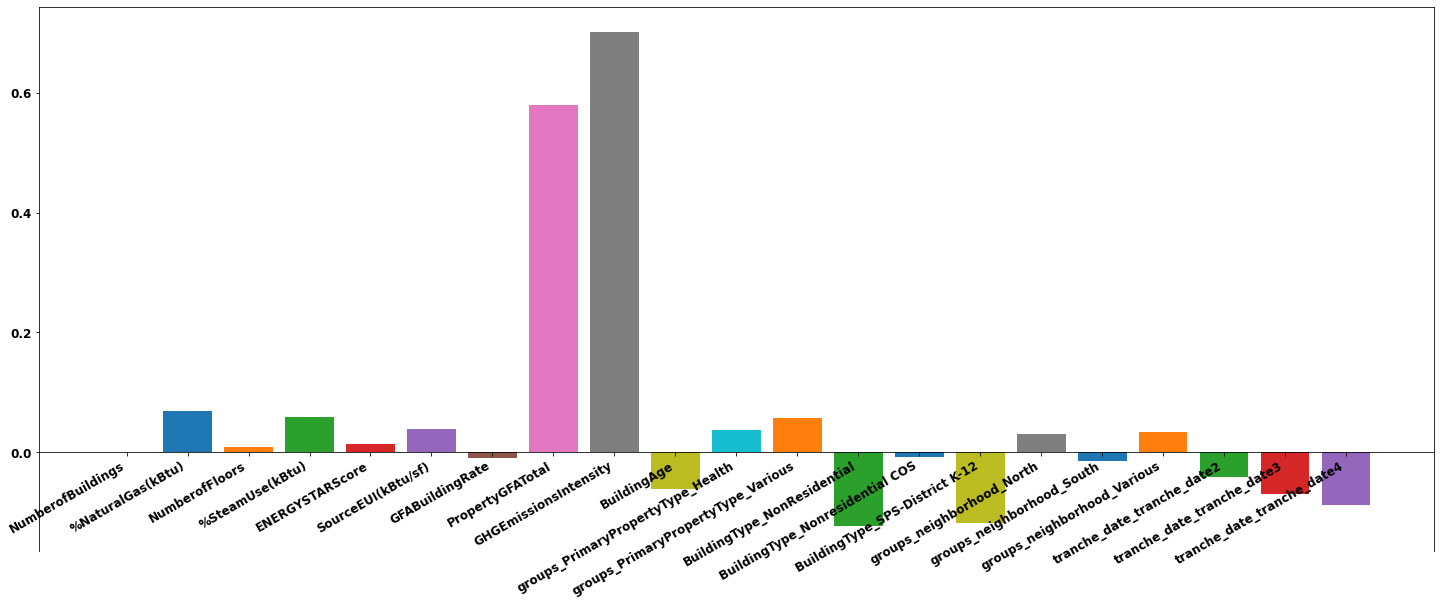

In [51]:
f_plot_coeff(clf_lr)

**Observations**
<br>
On peut remarquer que les features les plus importants sont: 'GHGEmissionsIntensity','BuildingType_Campus' et 'PropertyGFATotal'

### 4.1.3.Optimisation du modèle

### 4.1.4.Interprétation des features importance en se basant sur shap values

###### Interprétation  locale

In [ ]:

explainer=shap.Explainer(clf_lr["model"], feature_names=preprocessor.get_feature_names_out())
shap_values = explainer.shap_values(X_train)
i = 1000#c'est lenumero de la ligne choisi
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.loc[1000], feature_names=preprocessor.get_feature_names_out())

###### Interprétation  globale

In [ ]:
shap.summary_plot(shap_values, features=X_train, feature_names=preprocessor.get_feature_names_out())

#### Cross validation

In [52]:

scores = cross_val_score(clf_lr, X, y, cv=10,scoring='r2')#coefficient of determination (pr défaut). how well the regression model fits the observed data.a higher coefficient indicates a better fit for the model.
scores


array([0.85083974, 0.92538723, 0.96296171, 0.94682282, 0.91195931,
       0.94634104, 0.94425963, 0.93872602, 0.95369036, 0.90500864])

In [53]:
print(" mean of R2= %0.2f" % scores.mean())

 mean of R2= 0.93


#### Ajustement des paramètres en utilisant gridsearch

In [37]:
#Paramètres à ajuster
LinearRegression().get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize', 'positive'])

In [55]:

#LinearRegression().get_params().keys()
param_grid = {
    
    "model__fit_intercept": [True, False],
    "model__copy_X": [True, False],
    "model__positive": [True, False],
    "model__normalize": [True, False],
    #"model": [LinearRegression()]
}

grid_search = GridSearchCV(clf_lr, param_grid, cv=10)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          '%NaturalGas(kBtu)',
                                                                          'NumberofFloors',
                                                                          '%SteamUse(kBtu)',
                                                                          'ENERGYSTARScore',
                                                                          'SourceEUI(kBtu/sf)',
                                                                     

In [56]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__copy_X,param_model__fit_intercept,param_model__normalize,param_model__positive,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.035322,4.402594e-02,0.007805,0.007805,True,True,True,True,"{'model__copy_X': True, 'model__fit_intercept'...",0.923572,...,0.905984,0.949858,0.913594,0.956702,0.953885,0.956077,0.959137,0.942482,0.019167,9
1,0.015624,1.140678e-06,0.009372,0.007653,True,True,True,False,"{'model__copy_X': True, 'model__fit_intercept'...",0.924682,...,0.905119,0.951636,0.913628,0.957959,0.951301,0.956196,0.958967,0.942599,0.019281,5
2,0.015624,7.838861e-07,0.007812,0.007812,True,True,False,True,"{'model__copy_X': True, 'model__fit_intercept'...",0.923572,...,0.905984,0.949858,0.913594,0.956702,0.953885,0.956077,0.959137,0.942482,0.019167,9
3,0.017065,4.187696e-03,0.006327,0.006830,True,True,False,False,"{'model__copy_X': True, 'model__fit_intercept'...",0.924682,...,0.905119,0.951636,0.913628,0.957959,0.951301,0.956196,0.958967,0.942599,0.019281,5
4,0.015708,1.670760e-04,0.008613,0.007368,True,False,True,True,"{'model__copy_X': True, 'model__fit_intercept'...",0.921569,...,0.904395,0.950611,0.912100,0.957197,0.952597,0.955250,0.959440,0.942112,0.019838,13
5,0.015625,1.052558e-06,0.007812,0.007812,True,False,True,False,"{'model__copy_X': True, 'model__fit_intercept'...",0.924945,...,0.905344,0.951380,0.913496,0.957606,0.952081,0.956103,0.959193,0.942639,0.019229,1
6,0.014061,4.687119e-03,0.006250,0.007654,True,False,False,True,"{'model__copy_X': True, 'model__fit_intercept'...",0.921569,...,0.904395,0.950611,0.912100,0.957197,0.952597,0.955250,0.959440,0.942112,0.019838,13
7,0.015624,9.302878e-06,0.003125,0.006250,True,False,False,False,"{'model__copy_X': True, 'model__fit_intercept'...",0.924945,...,0.905344,0.951380,0.913496,0.957606,0.952081,0.956103,0.959193,0.942639,0.019229,1
8,0.017262,4.658308e-03,0.007085,0.007414,False,True,True,True,"{'model__copy_X': False, 'model__fit_intercept...",0.923572,...,0.905984,0.949858,0.913594,0.956702,0.953885,0.956077,0.959137,0.942482,0.019167,9
9,0.016489,2.599399e-03,0.008721,0.004183,False,True,True,False,"{'model__copy_X': False, 'model__fit_intercept...",0.924682,...,0.905119,0.951636,0.913628,0.957959,0.951301,0.956196,0.958967,0.942599,0.019281,5


In [57]:
grid_search.best_params_

{'model__copy_X': True,
 'model__fit_intercept': False,
 'model__normalize': True,
 'model__positive': False}

In [58]:
best_estim=grid_search.best_estimator_
f_performance(best_estim)

******************
MSE : 0.044
RMSE : 0.210
R2 : 0.958


**Observations**
<br>

pas bcp de paramètre avec la regression linéaire regardons la regression polynomial

In [59]:
numeric_transformer_pol = Pipeline(
    steps=[("scaler", StandardScaler()),('poly', PolynomialFeatures(degree=5))]
)

#categorical_transformer = OneHotEncoder(handle_unknown="ignore")
 #when using sklearn.compose.ColumnTransformer You need to make sure the output column is not included in the data you create your Preprocessing pipeline with
# Create ColumnTransformer to apply pipeline for each column type
preprocessor_pol = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_pol, numercial_cols_for_transformer),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

In [60]:

clf_pr = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LinearRegression())])
clf_pr.fit(X_train,y_train)
f_performance(clf_pr)


******************
MSE : 0.044
RMSE : 0.210
R2 : 0.958


### 4.2.Ridge regression

In [61]:
clf_rr = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", Ridge(alpha=2,solver='auto',fit_intercept=True))]
)
clf_rr.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   '%NaturalGas(kBtu)',
                                                   'NumberofFloors',
                                                   '%SteamUse(kBtu)',
                                                   'ENERGYSTARScore',
                                                   'SourceEUI(kBtu/sf)',
                                                   'GFABuildingRate',
                                                   'PropertyGFATotal',
                                                   'GHGEmissionsIntensity',
                                                   'BuildingAge']),
                                  

### 4.2.1.Indicateurs de performance

In [62]:
f_performance(clf_rr)

******************
MSE : 0.044
RMSE : 0.210
R2 : 0.958


 ### 4.2.2.Coéfficients du modèle

In [63]:
clf_rr.named_steps['model'].intercept_

array([0.06399501])

In [64]:
f_coeff(clf_rr)


,Columns,Estimated Coefficient
0,NumberofBuildings,0.002717
1,%NaturalGas(kBtu),0.071559
2,NumberofFloors,0.009361
3,%SteamUse(kBtu),0.060459
4,ENERGYSTARScore,0.013881
5,SourceEUI(kBtu/sf),0.043375
6,GFABuildingRate,-0.009494
7,PropertyGFATotal,0.577034
8,GHGEmissionsIntensity,0.696328
9,BuildingAge,-0.053853


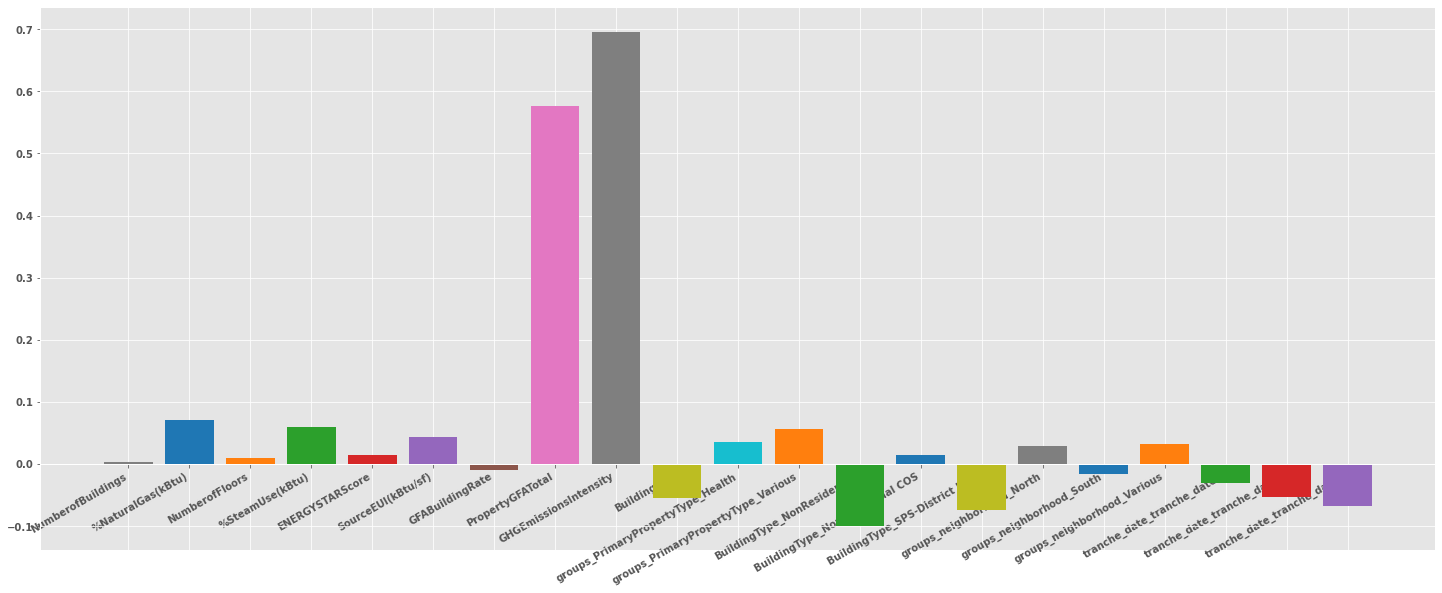

In [65]:
f_plot_coeff(clf_rr)

**Observations**
<br>
Pareil pour la regression linéaire,
on peut remarquer que les features les plus importants sont: 'GHGEmissionsIntensity','BuildingType_Campus' et 'PropertyGFATotal

### 4.2.3.Optimisation du modèle

#### Cross validation

In [66]:
scores = cross_val_score(clf_rr, X, y, cv=10,scoring='r2')#coefficient of determination (pr défaut). how well the regression model fits the observed data.a higher coefficient indicates a better fit for the model.
scores

array([0.85018738, 0.9248963 , 0.96280377, 0.94689395, 0.91282883,
       0.94643643, 0.9445412 , 0.93899553, 0.95355461, 0.90618323])

In [67]:

print(" mean of  R2= %0.2f" % scores.mean())

 mean of  R2= 0.93


#### Ajustement des paramètres 

In [54]:
Ridge().get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'random_state', 'solver', 'tol'])

In [55]:
#{'alpha': [1,0.1,0.01,0.001,0.0001,0] , "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

In [68]:
param_grid = {
    
    "model__alpha": [1,0.1,0.01,0.001,0.0001,0,5,10],
    "model__solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
    "model__fit_intercept": [True, False],
    "model__normalize": [True, False],
    #"model": [LinearRegression()]
}

grid_search = GridSearchCV(clf_rr, param_grid, cv=10)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          '%NaturalGas(kBtu)',
                                                                          'NumberofFloors',
                                                                          '%SteamUse(kBtu)',
                                                                          'ENERGYSTARScore',
                                                                          'SourceEUI(kBtu/sf)',
                                                                     

In [69]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__fit_intercept,param_model__normalize,param_model__solver,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.017413,0.003300,0.008693,0.006529,1,True,True,auto,"{'model__alpha': 1, 'model__fit_intercept': Tr...",0.783886,...,0.764074,0.801938,0.827136,0.822552,0.795186,0.755123,0.779737,0.783136,0.027297,205
1,0.035948,0.055956,0.009367,0.007648,1,True,True,svd,"{'model__alpha': 1, 'model__fit_intercept': Tr...",0.783886,...,0.764074,0.801938,0.827136,0.822552,0.795186,0.755123,0.779737,0.783136,0.027297,205
2,0.016901,0.006977,0.007914,0.006087,1,True,True,cholesky,"{'model__alpha': 1, 'model__fit_intercept': Tr...",0.783886,...,0.764074,0.801938,0.827136,0.822552,0.795186,0.755123,0.779737,0.783136,0.027297,205
3,0.021014,0.005519,0.005557,0.005044,1,True,True,lsqr,"{'model__alpha': 1, 'model__fit_intercept': Tr...",0.783923,...,0.764085,0.801866,0.827094,0.822621,0.795203,0.755147,0.779762,0.783130,0.027305,209
4,0.022750,0.012560,0.010942,0.010013,1,True,True,sparse_cg,"{'model__alpha': 1, 'model__fit_intercept': Tr...",0.783891,...,0.764052,0.801928,0.827153,0.822540,0.795198,0.755116,0.779694,0.783134,0.027297,208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.026053,0.002325,0.009701,0.001485,10,False,False,lsqr,"{'model__alpha': 10, 'model__fit_intercept': F...",0.925406,...,0.906850,0.950812,0.919491,0.958607,0.951889,0.954508,0.957691,0.942757,0.017671,22
252,0.023923,0.001190,0.008501,0.001566,10,False,False,sparse_cg,"{'model__alpha': 10, 'model__fit_intercept': F...",0.925309,...,0.906850,0.950826,0.919412,0.958813,0.951893,0.954471,0.957757,0.942765,0.017714,19
253,0.036922,0.007889,0.012995,0.004641,10,False,False,sag,"{'model__alpha': 10, 'model__fit_intercept': F...",0.925499,...,0.906730,0.950864,0.919153,0.958643,0.951886,0.954594,0.957718,0.942730,0.017744,46
254,0.039772,0.006892,0.011294,0.002411,10,False,False,saga,"{'model__alpha': 10, 'model__fit_intercept': F...",0.925535,...,0.906805,0.950861,0.919318,0.958632,0.951907,0.954528,0.957723,0.942758,0.017704,21


In [70]:
grid_search.best_params_


{'model__alpha': 5,
 'model__fit_intercept': False,
 'model__normalize': True,
 'model__solver': 'sparse_cg'}

In [71]:
best_estim=grid_search.best_estimator_
f_performance(best_estim)

******************
MSE : 0.044
RMSE : 0.210
R2 : 0.958


##### 

### 4.3.SVR

In [72]:
clf_svr = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", SVR(kernel='rbf',degree=3,gamma='scale'))]
)
clf_svr.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   '%NaturalGas(kBtu)',
                                                   'NumberofFloors',
                                                   '%SteamUse(kBtu)',
                                                   'ENERGYSTARScore',
                                                   'SourceEUI(kBtu/sf)',
                                                   'GFABuildingRate',
                                                   'PropertyGFATotal',
                                                   'GHGEmissionsIntensity',
                                                   'BuildingAge']),
                                  

### 4.3.1.Indicateurs de performance

In [73]:
f_performance(clf_svr)

******************
MSE : 0.040
RMSE : 0.200
R2 : 0.962


### 4.3.2.Coefficients du modèle

In [74]:

clf_svr.named_steps['model'].intercept_

array([0.28995021])

In [ ]:
#clf_svr.n_features_in_

In [ ]:
#clf_svr.feature_names_in_

### 4.3.3.Optimisation du modèle

#### Cross validation

In [75]:
scores = cross_val_score(clf_svr, X, y, cv=10,scoring='r2')#Ajustement-des-param%C3%A8trese(clf_svr, X, y, cv=10,scoring='r2')#coefficient of determination (pr défaut). how well the regression model fits the observed data.a higher coefficient indicates a better fit for the model.
scores

array([0.84637067, 0.9741497 , 0.97924932, 0.97366129, 0.97641573,
       0.93646731, 0.96152914, 0.9803658 , 0.9787399 , 0.96760626])

In [76]:
print(" mean of  R2= %0.2f" % scores.mean())

 mean of  R2= 0.96


#### Ajustement des paramètres

In [ ]:
SVR().get_params().keys()

In [78]:
param_grid = {
    
    "model__C": [1,0.1,0.01,0.001,0.0001,0.00001,0.00001,2,3,4,5,10],
    "model__epsilon": [0.0001, 0.001, 0.1, 1, 0.005, 0.0009],
    #"model__kernel": [True, False],
    #"model__gamma": [True, False],
    
}

grid_search = GridSearchCV(clf_svr, param_grid, cv=10)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          '%NaturalGas(kBtu)',
                                                                          'NumberofFloors',
                                                                          '%SteamUse(kBtu)',
                                                                          'ENERGYSTARScore',
                                                                          'SourceEUI(kBtu/sf)',
                                                                     

In [79]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__epsilon,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.275522,0.007164,0.033995,0.005552,1,0.0001,"{'model__C': 1, 'model__epsilon': 0.0001}",0.984808,0.967676,0.981833,0.940625,0.982530,0.968201,0.963275,0.982752,0.972675,0.984724,0.972910,0.013172,21
1,0.275024,0.010373,0.031248,0.000004,1,0.001,"{'model__C': 1, 'model__epsilon': 0.001}",0.984776,0.967610,0.981827,0.940588,0.982506,0.968158,0.963280,0.982791,0.972696,0.984702,0.972893,0.013180,23
2,0.079691,0.004683,0.014066,0.004689,1,0.1,"{'model__C': 1, 'model__epsilon': 0.1}",0.977776,0.958733,0.976466,0.932616,0.975198,0.955930,0.954055,0.977533,0.962869,0.976933,0.964811,0.014115,30
3,0.028143,0.006245,0.000000,0.000000,1,1,"{'model__C': 1, 'model__epsilon': 1}",0.712322,0.730328,0.759564,0.721007,0.786761,0.721767,0.680403,0.775221,0.704143,0.684161,0.727568,0.034311,41
4,0.242196,0.007813,0.032823,0.004683,1,0.005,"{'model__C': 1, 'model__epsilon': 0.005}",0.984692,0.967302,0.981831,0.940457,0.982208,0.968030,0.963195,0.982815,0.972799,0.984533,0.972786,0.013194,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,1.251984,0.043230,0.037598,0.001756,10,0.001,"{'model__C': 10, 'model__epsilon': 0.001}",0.989647,0.987127,0.988577,0.950406,0.985988,0.984020,0.965443,0.992297,0.982201,0.983791,0.980950,0.012323,2
68,0.086868,0.002938,0.015990,0.001479,10,0.1,"{'model__C': 10, 'model__epsilon': 0.1}",0.980059,0.977287,0.979152,0.945265,0.978341,0.962994,0.957222,0.988833,0.969881,0.979223,0.971826,0.012403,25
69,0.029883,0.001757,0.011995,0.002190,10,1,"{'model__C': 10, 'model__epsilon': 1}",0.736651,0.759490,0.762693,0.727860,0.798660,0.728040,0.668186,0.806278,0.740791,0.695337,0.742399,0.040156,36
70,1.014717,0.056832,0.038636,0.006895,10,0.005,"{'model__C': 10, 'model__epsilon': 0.005}",0.989821,0.986540,0.988686,0.950803,0.985961,0.984051,0.965432,0.992239,0.982264,0.984111,0.980991,0.012220,1


In [80]:
grid_search.best_params_

{'model__C': 10, 'model__epsilon': 0.005}

In [81]:
best_estim=grid_search.best_estimator_
f_performance(best_estim)

******************
MSE : 0.028
RMSE : 0.166
R2 : 0.974


In [177]:
#for parameter in model.get_params():
#    print(parameter)
#print(model.get_params()['gamma'])

### 4.4.LGBMRegressor

In [83]:
clf_lgb = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LGBMRegressor(boosting_type='gbdt',num_leaves=31,max_depth=1))]
)
clf_lgb.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   '%NaturalGas(kBtu)',
                                                   'NumberofFloors',
                                                   '%SteamUse(kBtu)',
                                                   'ENERGYSTARScore',
                                                   'SourceEUI(kBtu/sf)',
                                                   'GFABuildingRate',
                                                   'PropertyGFATotal',
                                                   'GHGEmissionsIntensity',
                                                   'BuildingAge']),
                                  

### 4.4.1.Indicateurs de performance

In [84]:
f_performance(clf_lgb)

******************
MSE : 0.054
RMSE : 0.233
R2 : 0.948


### 4.4.2.Optimisation du modèle

In [52]:
#### Cross validation

#### Ajustement des paramètres

In [33]:
list(clf_lgb.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__num',
 'preprocessor__cat',
 'preprocessor__num__memory',
 'preprocessor__num__steps',
 'preprocessor__num__verbose',
 'preprocessor__num__scaler',
 'preprocessor__num__scaler__copy',
 'preprocessor__num__scaler__with_mean',
 'preprocessor__num__scaler__with_std',
 'preprocessor__cat__categories',
 'preprocessor__cat__drop',
 'preprocessor__cat__dtype',
 'preprocessor__cat__handle_unknown',
 'preprocessor__cat__sparse',
 'model__boosting_type',
 'model__class_weight',
 'model__colsample_bytree',
 'model__importance_type',
 'model__learning_rate',
 'model__max_depth',
 'model__min_child_samples',
 'model__min_child_weight',
 'model__min_split_gain',
 'model__n_estimators',
 'model__n_jobs'

In [85]:
param_grid = {
    
    "model__max_depth": [5,10,20,15,30],
    "model__num_leaves": [150,50,10,20,5,100],
     "model__boosting_type": ['gbdt', 'rbf','dart','goss'],
    "model__learning_rate": [0.1, 0.01,1,0.5,0.6,0.7,0.4],
    
}

grid_search = GridSearchCV(clf_lgb, param_grid, cv=10)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['NumberofBuildings',
                                                                          '%NaturalGas(kBtu)',
                                                                          'NumberofFloors',
                                                                          '%SteamUse(kBtu)',
                                                                          'ENERGYSTARScore',
                                                                          'SourceEUI(kBtu/sf)',
                                                                     

In [86]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__boosting_type,param_model__learning_rate,param_model__max_depth,param_model__num_leaves,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.274687,0.029833,0.002480,0.005157,gbdt,0.1,5,150,"{'model__boosting_type': 'gbdt', 'model__learn...",0.985318,...,0.945811,0.989637,0.989021,0.990977,0.992188,0.994163,0.993309,0.985254,0.013474,37
1,0.248776,0.011032,0.009904,0.008230,gbdt,0.1,5,50,"{'model__boosting_type': 'gbdt', 'model__learn...",0.985318,...,0.945811,0.989637,0.989021,0.990977,0.992188,0.994163,0.993309,0.985254,0.013474,37
2,0.201922,0.014857,0.007815,0.007815,gbdt,0.1,5,10,"{'model__boosting_type': 'gbdt', 'model__learn...",0.984503,...,0.940950,0.990562,0.987359,0.990956,0.992354,0.993161,0.993957,0.984849,0.014927,53
3,0.239545,0.015216,0.007813,0.007813,gbdt,0.1,5,20,"{'model__boosting_type': 'gbdt', 'model__learn...",0.985539,...,0.943211,0.990018,0.988954,0.991011,0.992452,0.992997,0.993675,0.985112,0.014228,44
4,0.135611,0.009772,0.010367,0.008655,gbdt,0.1,5,5,"{'model__boosting_type': 'gbdt', 'model__learn...",0.988914,...,0.940431,0.991133,0.985744,0.991107,0.990441,0.994503,0.991470,0.984459,0.014994,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.290651,0.014295,0.006250,0.007655,goss,0.4,30,50,"{'model__boosting_type': 'goss', 'model__learn...",0.975304,...,0.931928,0.978395,0.979133,0.982208,0.987467,0.978073,0.979883,0.973880,0.014811,281
836,0.230999,0.011964,0.003125,0.006250,goss,0.4,30,10,"{'model__boosting_type': 'goss', 'model__learn...",0.967381,...,0.940841,0.977631,0.972275,0.975643,0.985054,0.967847,0.969539,0.970499,0.011106,345
837,0.275866,0.013052,0.007814,0.007814,goss,0.4,30,20,"{'model__boosting_type': 'goss', 'model__learn...",0.974512,...,0.927219,0.978649,0.963376,0.976898,0.983434,0.975063,0.974201,0.969640,0.015038,363
838,0.144609,0.010429,0.010939,0.007161,goss,0.4,30,5,"{'model__boosting_type': 'goss', 'model__learn...",0.968199,...,0.939145,0.980663,0.976198,0.979501,0.984739,0.976847,0.975962,0.973368,0.012141,294


In [87]:
grid_search.best_params_

{'model__boosting_type': 'dart',
 'model__learning_rate': 0.4,
 'model__max_depth': 15,
 'model__num_leaves': 150}

In [88]:
best_estim=grid_search.best_estimator_
f_performance(best_estim)

******************
MSE : 0.028
RMSE : 0.168
R2 : 0.973


## 4.5.RandomForestRegressor

In [34]:
clf_rf = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", RandomForestRegressor(n_estimators=300,max_leaf_nodes=1000,criterion='squared_error'))]
)
clf_rf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SourceEUI(kBtu/sf)',
                                                   'NumberofFloors',
                                                   'BuildingAge',
                                                   'GHGEmissionsIntensity',
                                                   'PropertyGFATotal',
                                                   'NumberofBuildings',
                                                   'ENERGYSTARScore']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                     

### 4.5.1.Indicateurs de performance

In [35]:
f_performance(clf_rf)

******************
MSE : 0.181
RMSE : 0.425
R2 : 0.819


### 4.5.2.Optimisation du modèle

In [36]:
list(clf_rf.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__num',
 'preprocessor__cat',
 'preprocessor__num__memory',
 'preprocessor__num__steps',
 'preprocessor__num__verbose',
 'preprocessor__num__scaler',
 'preprocessor__num__scaler__copy',
 'preprocessor__num__scaler__with_mean',
 'preprocessor__num__scaler__with_std',
 'preprocessor__cat__categories',
 'preprocessor__cat__drop',
 'preprocessor__cat__dtype',
 'preprocessor__cat__handle_unknown',
 'preprocessor__cat__sparse',
 'model__bootstrap',
 'model__ccp_alpha',
 'model__criterion',
 'model__max_depth',
 'model__max_features',
 'model__max_leaf_nodes',
 'model__max_samples',
 'model__min_impurity_decrease',
 'model__min_samples_leaf',
 'model__min_samples_split',
 'model__min_weight_fracti

In [39]:
param_grid = {
    
    "model__max_leaf_nodes": [1000,5000,100000,None],
    "model__n_estimators": [150,50,10,250,100],
     "model__criterion": ['squared_error', 'absolute_error', 'poisson']
    
}
grid_search = GridSearchCV(clf_rf, param_grid, cv=10)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SourceEUI(kBtu/sf)',
                                                                          'NumberofFloors',
                                                                          'BuildingAge',
                                                                          'GHGEmissionsIntensity',
                                                                          'PropertyGFATotal',
                                                                          'NumberofBuildings',
                                                                    

In [40]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_leaf_nodes,param_model__n_estimators,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,1.235810,0.051455,0.034659,6.190005e-03,squared_error,1000,150,"{'model__criterion': 'squared_error', 'model__...",0.770524,0.827315,...,0.693124,0.794743,0.854187,0.774557,0.774623,0.801739,0.786490,0.787243,0.039843,14
1,0.428158,0.017367,0.017189,4.686515e-03,squared_error,1000,50,"{'model__criterion': 'squared_error', 'model__...",0.771979,0.826657,...,0.689270,0.791459,0.848125,0.765537,0.767325,0.802081,0.782436,0.782573,0.040054,32
2,0.095305,0.004687,0.010952,7.169625e-03,squared_error,1000,10,"{'model__criterion': 'squared_error', 'model__...",0.746031,0.811385,...,0.674965,0.786020,0.818058,0.754737,0.754133,0.792312,0.751151,0.764870,0.038809,39
3,2.028242,0.027768,0.050011,6.243204e-03,squared_error,1000,250,"{'model__criterion': 'squared_error', 'model__...",0.775747,0.830181,...,0.704650,0.792418,0.850576,0.775838,0.773812,0.807358,0.784881,0.788157,0.036809,7
4,0.828063,0.051981,0.025001,7.654130e-03,squared_error,1000,100,"{'model__criterion': 'squared_error', 'model__...",0.774419,0.834681,...,0.710001,0.793383,0.850772,0.765663,0.762001,0.805934,0.778287,0.786807,0.037440,18
5,1.235894,0.022253,0.032812,4.686952e-03,squared_error,5000,150,"{'model__criterion': 'squared_error', 'model__...",0.773079,0.825579,...,0.701369,0.791862,0.850841,0.770967,0.775633,0.807113,0.784880,0.787313,0.037325,13
6,0.431284,0.028135,0.018751,6.249499e-03,squared_error,5000,50,"{'model__criterion': 'squared_error', 'model__...",0.771545,0.827661,...,0.710311,0.785841,0.848384,0.760372,0.763141,0.798309,0.789374,0.784443,0.035910,29
7,0.096879,0.006244,0.009375,7.654967e-03,squared_error,5000,10,"{'model__criterion': 'squared_error', 'model__...",0.742813,0.814829,...,0.709604,0.777278,0.831094,0.762883,0.761612,0.789349,0.750571,0.769871,0.033441,34
8,2.048421,0.062744,0.049998,6.249285e-03,squared_error,5000,250,"{'model__criterion': 'squared_error', 'model__...",0.774959,0.826081,...,0.699128,0.789415,0.851055,0.770582,0.771927,0.806884,0.784643,0.785883,0.037942,24
9,0.828179,0.027067,0.025000,7.654003e-03,squared_error,5000,100,"{'model__criterion': 'squared_error', 'model__...",0.776885,0.822717,...,0.700846,0.792048,0.851775,0.775123,0.776099,0.807875,0.782563,0.786461,0.037153,20


In [41]:
grid_search.best_params_

{'model__criterion': 'absolute_error',
 'model__max_leaf_nodes': 100000,
 'model__n_estimators': 150}

In [42]:
best_estim=grid_search.best_estimator_
f_performance(best_estim)

******************
MSE : 0.178
RMSE : 0.422
R2 : 0.822


## 4.6.XGBRegressor

In [50]:
clf_xg = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123))]
)
clf_xg.fit(X_train,y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['SourceEUI(kBtu/sf)',
                                                   'NumberofFloors',
                                                   'BuildingAge',
                                                   'GHGEmissionsIntensity',
                                                   'PropertyGFATotal',
                                                   'NumberofBuildings',
                                                   'ENERGYSTARScore']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                     

### 4.6.1.Indicateurs de performance

In [51]:
f_performance(clf_xg)

******************
MSE : 0.181
RMSE : 0.426
R2 : 0.819


### 4.6.2.Optimisation du modèle

In [65]:
list(clf_xg.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'model',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__num',
 'preprocessor__cat',
 'preprocessor__num__memory',
 'preprocessor__num__steps',
 'preprocessor__num__verbose',
 'preprocessor__num__scaler',
 'preprocessor__num__scaler__copy',
 'preprocessor__num__scaler__with_mean',
 'preprocessor__num__scaler__with_std',
 'preprocessor__cat__categories',
 'preprocessor__cat__drop',
 'preprocessor__cat__dtype',
 'preprocessor__cat__handle_unknown',
 'preprocessor__cat__sparse',
 'model__objective',
 'model__base_score',
 'model__booster',
 'model__callbacks',
 'model__colsample_bylevel',
 'model__colsample_bynode',
 'model__colsample_bytree',
 'model__early_stopping_rounds',
 'model__enable_categorical',
 'model__eval_metric',
 'model__gamma',
 '

In [62]:
param = {"booster":"gblinear", "objective":"reg:linear"}
clf_test = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", XGBRegressor(objective ='reg:squarederror',booster="dart",
                  n_estimators = 100))]
)
clf_test.fit(X_train,y_train)
f_performance(clf_test)

******************
MSE : 0.177
RMSE : 0.421
R2 : 0.823


In [66]:
param_grid = {
    
    "model__booster": ['squarederror','gbtree'],
    "model__n_estimators": [150,50,10,20,500,100,5],
    
    "model__max_leaves": [10000, 100000,1000,100],
    "model__learning_rate": [0.3, 0.5,0.1,0.01,0.001]
    
}

grid_search = GridSearchCV(clf_xg, param_grid, cv=10)
grid_search.fit(X_train,y_train)

[16:27:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:57] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:27:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:27:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:00] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:28] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:28:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:29:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:29:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:19] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:29:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:29:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:30:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:30:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:17] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:30:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:33] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:34] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:30:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:30:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:31:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:07] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:31:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:31:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:38] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:31:59] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:04] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:32:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:18] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:32:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:43] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:44] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:45] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:32:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:33:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:12] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:13] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:33:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:26] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:33:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:53] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:33:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:34:22] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:25] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:34:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:35] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:34:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:35:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:35:30] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:31] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:32] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:35:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:35:42] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:36:10] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:11] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:36:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:37] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:36:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:49] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:37:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:16] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:37:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:40] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:41] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

[16:37:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:54] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:20

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['SourceEUI(kBtu/sf)',
                                                                          'NumberofFloors',
                                                                          'BuildingAge',
                                                                          'GHGEmissionsIntensity',
                                                                          'PropertyGFATotal',
                                                                          'NumberofBuildings',
                                                                    

In [67]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results
grid_search.best_params_
best_estim=grid_search.best_estimator_
f_performance(best_estim)

******************
MSE : 0.176
RMSE : 0.420
R2 : 0.824
